In [1]:
import pandas as pd

file = 'model/efficient_labelled_1.0_0511151159/csv_logs/lightning_logs/version_0/metrics.csv'
df = pd.read_csv(file)

In [2]:
df.columns

Index(['epoch', 'step', 'train_acc_epoch', 'train_acc_step',
       'train_loss_epoch', 'train_loss_step', 'val_acc', 'val_loss'],
      dtype='object')

We can observe the evolution of the training accuracy by epoch, as the model learns the data.

In [3]:
# evolution of train_acc_epoch by epochs 
df.iloc[df['train_acc_epoch'].dropna().index][['train_loss_epoch', 'train_acc_epoch']]

,train_loss_epoch,train_acc_epoch
541,2.588709,0.434178
1084,1.818211,0.589161
1627,1.542749,0.644817
2169,1.354655,0.683149
2712,1.206732,0.714430
3255,1.094926,0.737706
3797,0.798222,0.805320
4340,0.682118,0.830272


However, alidation accuracy does not increase at a similar, showing that the model is overfitting.

In [4]:
df[['val_acc', 'val_loss']].dropna()

,val_acc,val_loss
540,0.434374,2.694858
1083,0.384066,2.954183
1626,0.481793,2.478314
2168,0.444686,2.756868
2711,0.474603,2.570438
3254,0.490440,2.517863
3796,0.510762,2.555993
4339,0.475782,2.813143


In [6]:
import matplotlib.pyplot as plt

def plot_column_evolution(df: pd.DataFrame, col: str, col_val:str, footer_note: str = ''):
    plt.figure(figsize=(10, 6))
    step_col = df.columns[0]
    epoch_col = df.columns[1]
    for epoch in df[epoch_col].unique():
        subset = df[df[epoch_col] == epoch]
        plt.plot(subset[step_col], subset[col], label=f'Epoch {epoch}')

    plt.xlabel('Step')
    plt.ylabel(col)
    plt.title(f'{col} by Step (Colored by Epochs)')
    plt.grid(True)
    
    if footer_note:
        plt.figtext(0.5, 0.01, footer_note, wrap=True, horizontalalignment='center', fontsize=10)

    clean_df = df[[step_col, col_val]].dropna()
    plt.plot(clean_df[step_col], clean_df[col_val], color='black', linewidth=3, label=col_val)

    plt.legend()
    plt.show()

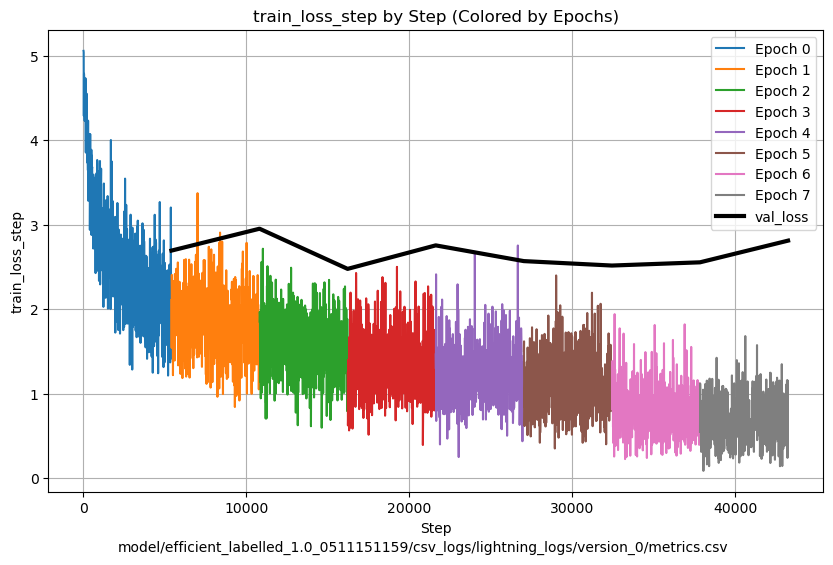

In [ ]:
plot_column_evolution(df, 'train_loss_step', 'val_loss', file)

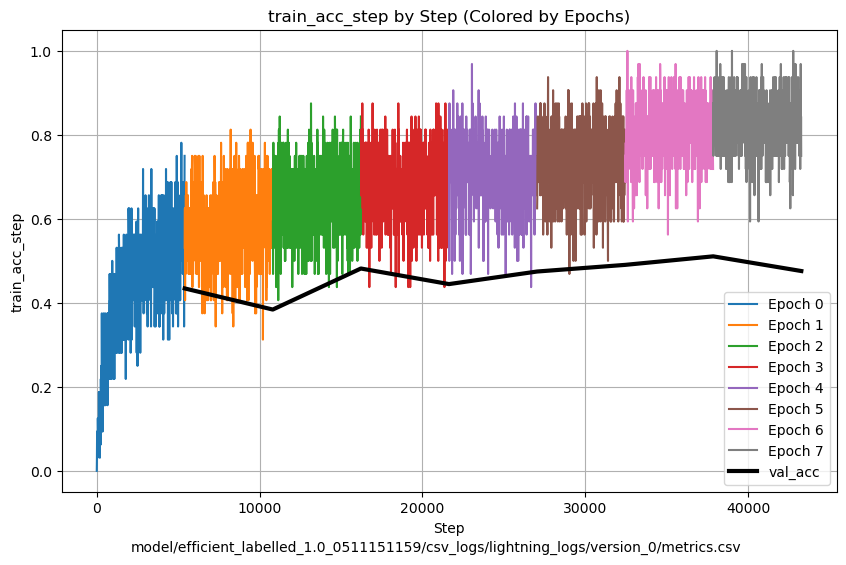

In [6]:
plot_column_evolution(df, 'train_acc_step', 'val_acc', file)

In [4]:
import pandas as pd

file = 'model/20250521_124614_efficientb0/metrics.csv'
df = pd.read_csv(file)
df.columns = df.columns.str.strip()

In [8]:
df.columns

Index(['step', 'epoch', 'fold', 'train_loss', 'train_auc', 'val_loss',
       'val_auc', 'val_acc', 'val_bal_acc', 'lr', 'time'],
      dtype='object')

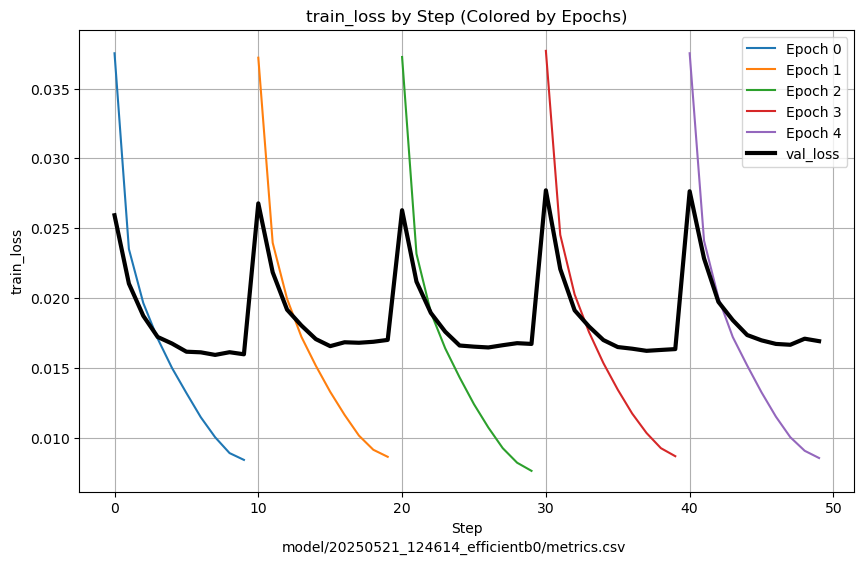

In [7]:
plot_column_evolution(df, 'train_loss', 'val_loss', file)

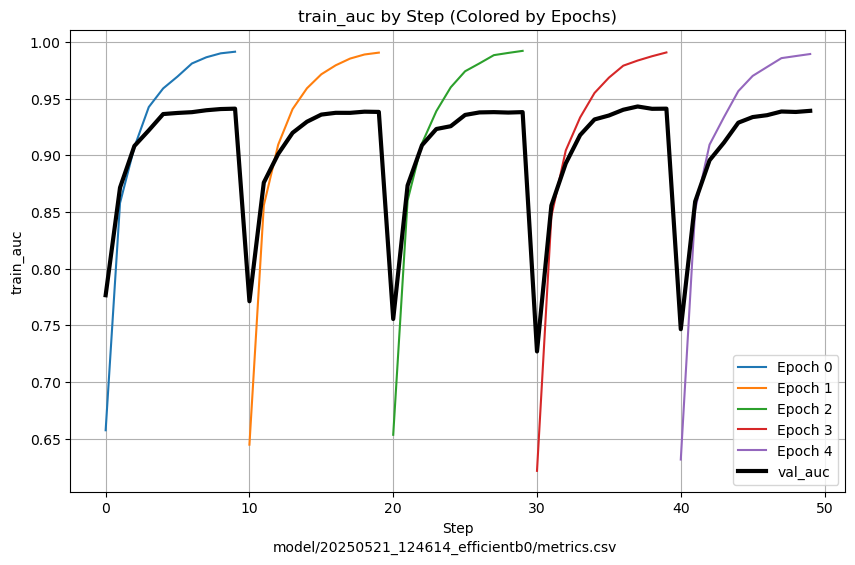

In [8]:
plot_column_evolution(df, 'train_auc', 'val_auc', file)

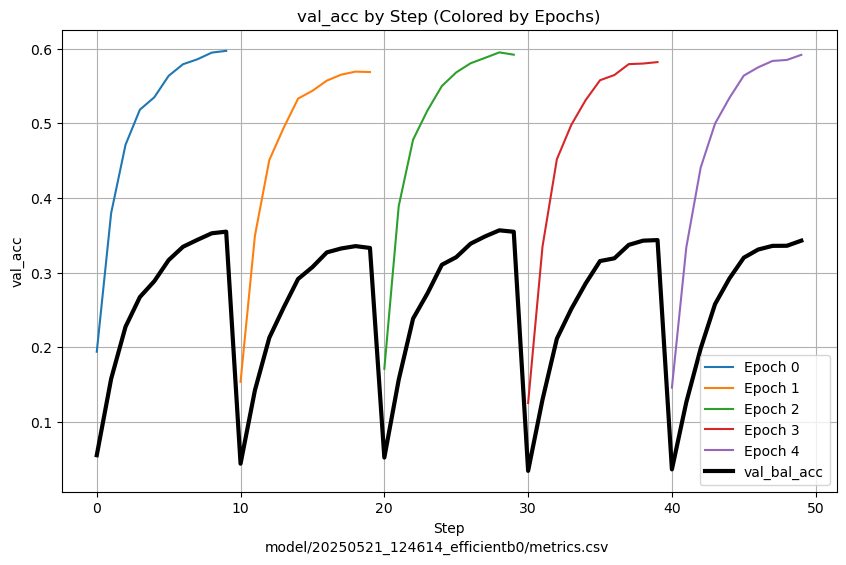

In [9]:
plot_column_evolution(df, 'val_acc', 'val_bal_acc', file)

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import matplotlib.ticker as ticker

confusion_results = 'model/20250521_124614_efficientb0/confusion_results.csv'
taxonomy_df = pd.read_csv('data/taxonomy.csv')

# Get sorted class mapping
primary_label = taxonomy_df['primary_label'].tolist()
class_name = taxonomy_df['class_name'].tolist()
sorted_class_indices = np.argsort(class_name)
mapping = np.empty(len(class_name), dtype=int)
mapping[sorted_class_indices] = np.arange(len(class_name))
sorted_class_names = [class_name[i] for i in sorted_class_indices]

# Load and remap predictions
df = pd.read_csv(confusion_results)
all_targets = mapping[df["target"].astype(int).values]
all_predicted = mapping[df["prediction"].astype(int).values]

# Limit to used classes
used = np.unique(np.concatenate((all_targets, all_predicted)))
conf_matrix = confusion_matrix(all_targets, all_predicted, labels=used)
labels = [sorted_class_names[i] for i in used]

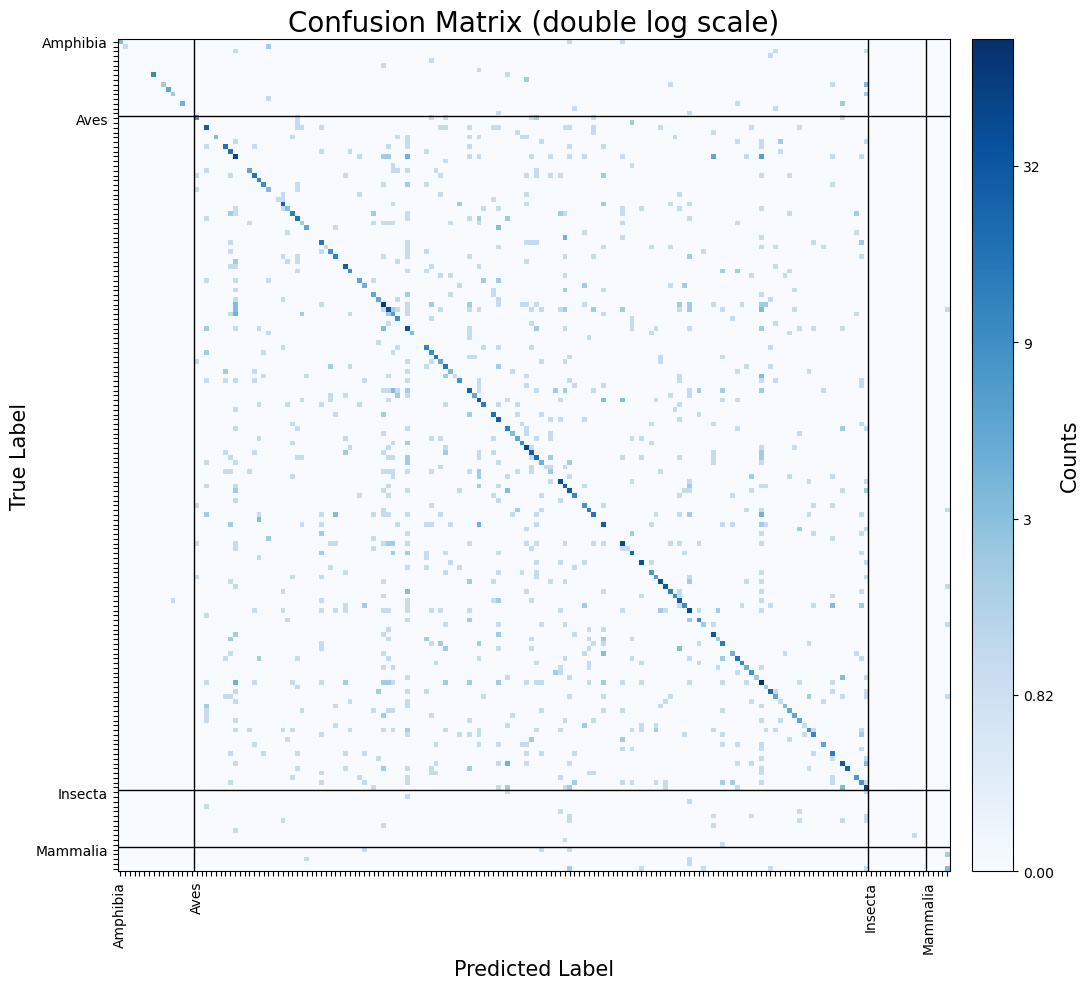

In [11]:
# Identify block boundaries and reduce tick labels
display_labels = [''] * len(labels)
boundary_indices = []
prev_label = None
for i, lbl in enumerate(labels):
    if lbl != prev_label:
        display_labels[i] = lbl
        if i > 0:
            boundary_indices.append(i - 0.5)
        prev_label = lbl

# Plot with double log scale
conf_log = np.log10(np.log10(conf_matrix + 1) + 1)
plt.figure(figsize=(12, 10))
plt.imshow(conf_log, interpolation='nearest', cmap='Blues')
plt.xticks(ticks=np.arange(len(labels)), labels=display_labels, rotation=90)
plt.yticks(ticks=np.arange(len(labels)), labels=display_labels)

def inverse_double_log(x, pos):
    val = 10**(10**x - 1) - 1
    # Format large values nicely
    if val >= 1000:
        return f"{int(val):,}"
    elif val >= 1:
        return f"{val:.0f}"
    else:
        return f"{val:.2f}"

cbar = plt.colorbar(fraction=0.05, pad=0.02)
cbar.set_label("Counts", fontsize=15)
cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(inverse_double_log))

# Draw black lines at group boundaries
for b in boundary_indices:
    plt.axhline(b, color='black', linewidth=1)
    plt.axvline(b, color='black', linewidth=1)

plt.title("Confusion Matrix (double log scale)", fontsize=20)
plt.xlabel("Predicted Label", fontsize=15)
plt.ylabel("True Label", fontsize=15)
plt.tight_layout()
plt.show()

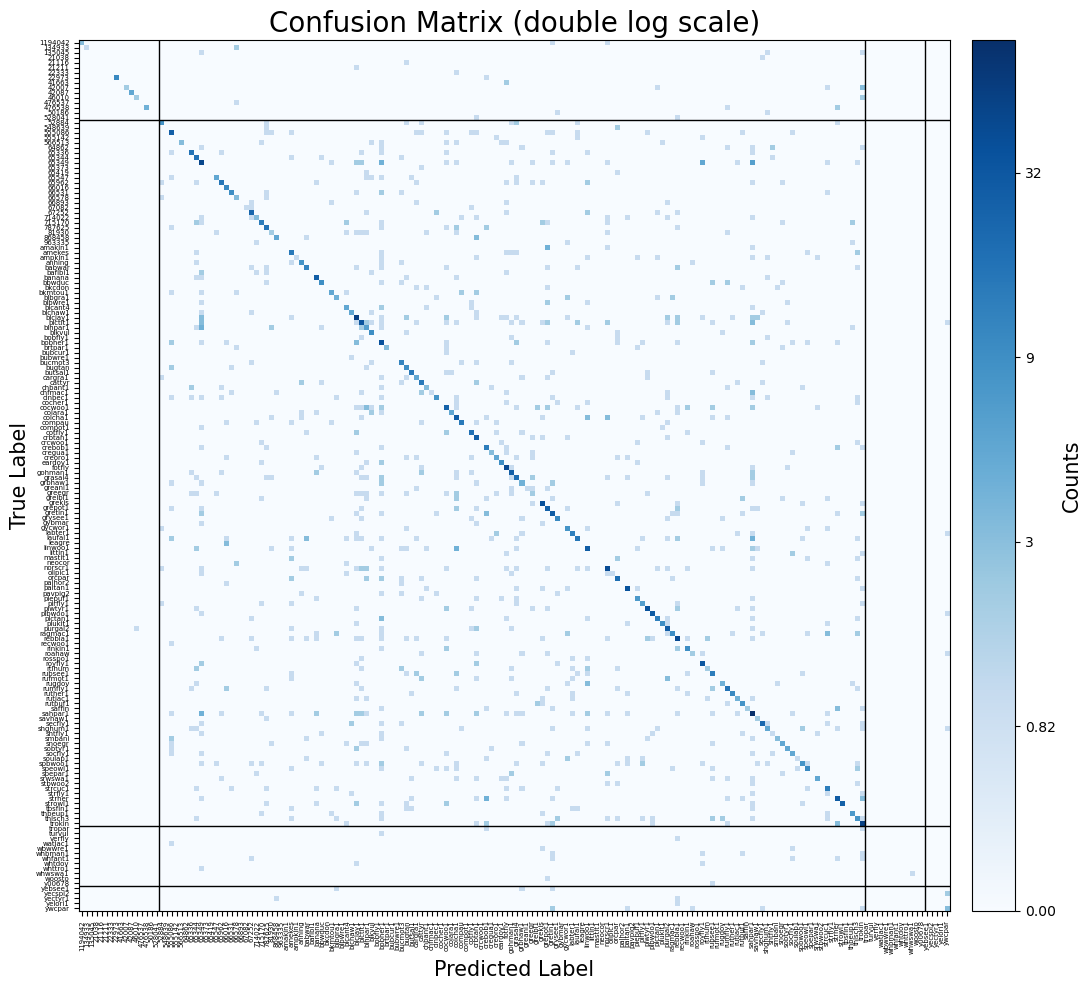

In [12]:
display_labels = [primary_label[i] for i in used]

# Plot with double log scale
conf_log = np.log10(np.log10(conf_matrix + 1) + 1)
plt.figure(figsize=(12, 10))
im = plt.imshow(conf_log, interpolation='nearest', cmap='Blues')

plt.xticks(ticks=np.arange(len(display_labels)), labels=display_labels, fontsize=5, rotation=90)
plt.yticks(ticks=np.arange(len(display_labels)), labels=display_labels, fontsize=5)

def inverse_double_log(x, pos):
    val = 10**(10**x - 1) - 1
    if val >= 1000:
        return f"{int(val):,}"
    elif val >= 1:
        return f"{val:.0f}"
    else:
        return f"{val:.2f}"

cbar = plt.colorbar(im, fraction=0.05, pad=0.02)
cbar.set_label("Counts", fontsize=15)
cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(inverse_double_log))

# Draw black lines ONLY where class_name changes
for b in boundary_indices:
    plt.axhline(b, color='black', linewidth=1)
    plt.axvline(b, color='black', linewidth=1)

plt.title("Confusion Matrix (double log scale)", fontsize=20)
plt.xlabel("Predicted Label", fontsize=15)
plt.ylabel("True Label", fontsize=15)
plt.tight_layout()
plt.show()